In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [88]:
# Data Load
df_train = pd.read_csv('train.csv').dropna()
df_train.head(1)
df_train.columns = ['id', 'hour', 'temp', 'precip',
       'windspeed', 'humidity', 'visibility',
       'ozone', 'pm10', 'pm2_5', 'count']
print(df_train.head(1))
print(len(df_train))

   id  hour  temp  precip  windspeed  ...  visibility  ozone  pm10  pm2_5  count
0   3    20  16.3     1.0        1.5  ...       576.0  0.027  76.0   33.0   49.0

[1 rows x 11 columns]
1328


In [89]:
# OLS
model = smf.ols(
    "count ~ hour + temp + C(precip) + windspeed + humidity + visibility + ozone + pm10 + pm2_5",
    data = df_train
)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.591
Model:                            OLS   Adj. R-squared:                  0.588
Method:                 Least Squares   F-statistic:                     211.9
Date:                Sat, 09 Apr 2022   Prob (F-statistic):          8.62e-249
Time:                        15:14:04   Log-Likelihood:                -7156.4
No. Observations:                1328   AIC:                         1.433e+04
Df Residuals:                    1318   BIC:                         1.438e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          -37.8962     19.405     -1.953      0.051     -75.964       0.172
C(precip)[T.1.0]   -54.9233      9.031     -6.082      0.000     -72.640     -37.206
hour                 4.7873      0.258     18.587      0.000       4.282       5.293
temp                 5.2831      0.368     14.366      0.000       4.562       6.005
windspeed            5.2533      1.378      3.812      0.000       2.550       7.957
humidity            -0.2821      0.127     -2.224      0.026      -0.531      -0.033
visibility           0.0058      0.005      1.179      0.239      -0.004       0.015
ozone              293.1422     99.597      2.943      0.003      97.755     488.529
pm10                -0.3193      0.060     -5.290      0.000      -0.438      -0.201
pm2_5                0.1492      0.144      1.034      0.301      -0.134       0.432
==============================================================================
Omnibus:                      181.982   Durbin-Watson:                   1.983
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              295.291
Skew:                           0.914   Prob(JB):                     7.56e-65
Kurtosis:                       4.413   Cond. No.                     1.04e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [90]:
# VIF 
from statsmodels.stats.outliers_influence import variance_inflation_factor
for i in range(1, len(model.exog_names)):
    vif = variance_inflation_factor(model.exog, i)
    print(f'Variable : {model.exog_names[i]},   VIF : {vif.round(2)}')

Variable : C(precip)[T.1.0],   VIF : 1.12
Variable : hour,   VIF : 1.42
Variable : temp,   VIF : 1.71
Variable : windspeed,   VIF : 1.7
Variable : humidity,   VIF : 3.07
Variable : visibility,   VIF : 3.73
Variable : ozone,   VIF : 1.76
Variable : pm10,   VIF : 1.67
Variable : pm2_5,   VIF : 2.12


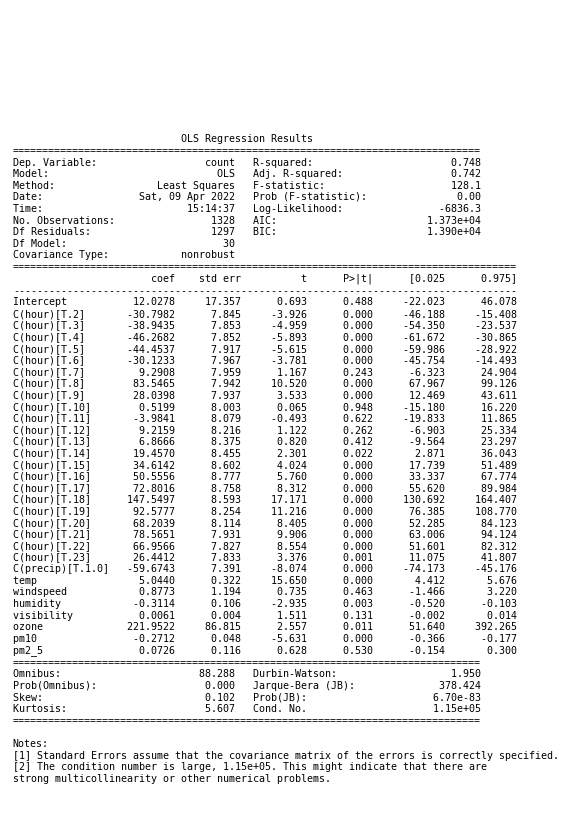

In [94]:
# hour as dummy_variable
model = smf.ols(
    "count ~ C(hour) + temp + C(precip) + windspeed + humidity + visibility + ozone + pm10 + pm2_5",
    data = df_train
)
results = model.fit()
results.summary()

fig, ax = plt.subplots(1,1)
plt.rc('figure', figsize=(10, 15))
plt.text(0.01, 0.05, str(results.summary()), {'fontsize': 10}, fontproperties = 'monospace') # approach improved by OP -> monospace!
plt.axis('off')
plt.savefig('model_new.png', transparent = False, facecolor = 'white')

In [113]:
# Model split
from sklearn.model_selection import train_test_split

X, y = df_train.iloc[:,1:-1], df_train.iloc[:,-1]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=37)
print(len(X_train))

929


In [114]:
# Dummy, const treatment
X_train = pd.get_dummies(X_train, columns=['precip'], drop_first = True)
X_train = sm.add_constant(X_train)
X_val = pd.get_dummies(X_val, columns=['precip'], drop_first = True)
X_val = sm.add_constant(X_val)

In [115]:
# Modeling
ols = sm.OLS(y_train, X_train, missing='drop')
ols_res = ols.fit()
print(ols_res.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.604
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     155.7
Date:                Sat, 09 Apr 2022   Prob (F-statistic):          4.86e-178
Time:                        19:55:16   Log-Likelihood:                -5007.7
No. Observations:                 929   AIC:                         1.004e+04
Df Residuals:                     919   BIC:                         1.008e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -59.5871     23.651     -2.519      0.0

In [117]:
# Validation
from sklearn.metrics import mean_squared_error
pred_val = ols_res.predict(X_val)
rmse = mean_squared_error(y_val, pred_val)
print(f'RMSE : {np.sqrt(rmse).round(3)}') # Result : 53.242

RMSE : 53.242


eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1


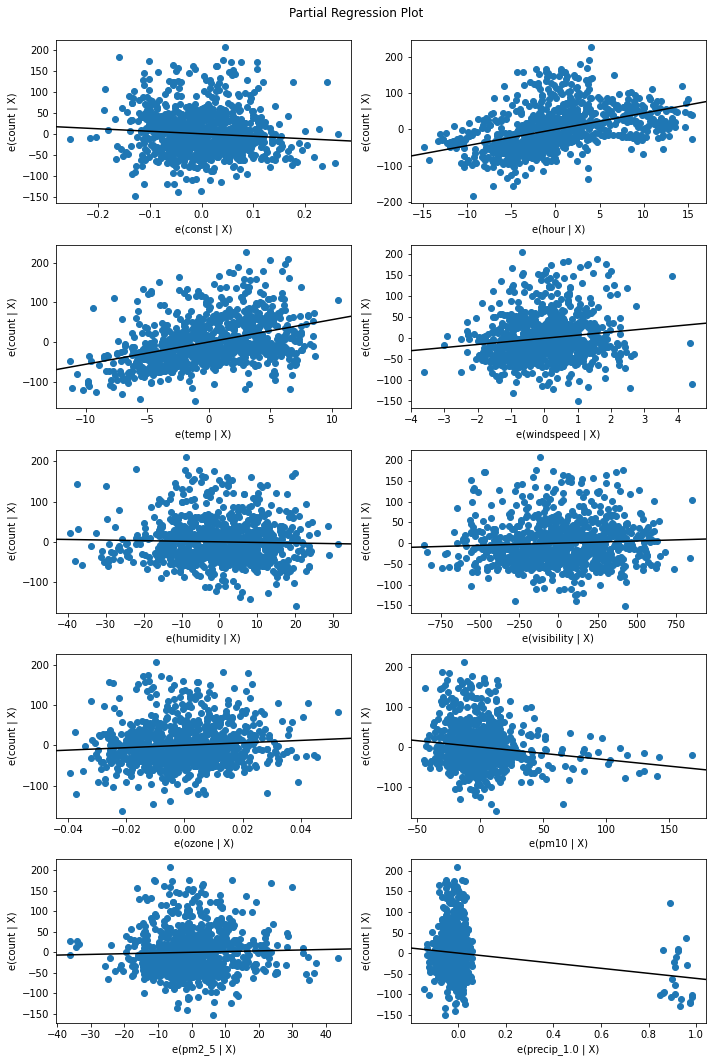

In [119]:
fig = sm.graphics.plot_partregress_grid(ols_res)
plt.savefig('PRP.png', transparent = False, facecolor = 'white')